In [107]:
import pandas as pd 
import numpy as np
import re
import collections
import matplotlib.pyplot as plt

# Packages for data preparation
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from keras.preprocessing.text import Tokenizer
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import LabelEncoder

# Packages for modeling
from keras import models
from keras import layers
from keras import regularizers

In [108]:
import pandas as pd

In [109]:
df= pd.read_csv("airline_sentiment_analysis.csv")

In [110]:
df.head()

,Unnamed: 0,airline_sentiment,text
0,1,positive,@VirginAmerica plus you've added commercials t...
1,3,negative,@VirginAmerica it's really aggressive to blast...
2,4,negative,@VirginAmerica and it's a really big bad thing...
3,5,negative,@VirginAmerica seriously would pay $30 a fligh...
4,6,positive,"@VirginAmerica yes, nearly every time I fly VX..."


In [111]:
df = df[['text', 'airline_sentiment']]
df.head()

,text,airline_sentiment
0,@VirginAmerica plus you've added commercials t...,positive
1,@VirginAmerica it's really aggressive to blast...,negative
2,@VirginAmerica and it's a really big bad thing...,negative
3,@VirginAmerica seriously would pay $30 a fligh...,negative
4,"@VirginAmerica yes, nearly every time I fly VX...",positive


In [112]:
NB_WORDS = 10000  # Parameter indicating the number of words we'll put in the dictionary
VAL_SIZE = 1000  # Size of the validation set
NB_START_EPOCHS = 20  # Number of epochs for training
BATCH_SIZE = 512  # Size of the batches

In [113]:
import nltk
nltk.download('stopwords')
stopword = nltk.corpus.stopwords.words('english')
print(stopword)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dell\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [114]:
def remove_stopwords(input_text):
    stopwords_list = stopwords.words('english')
    # Some words which might indicate a certain sentiment are kept in whitelist
    whitelist = ["n't", "not", "no"]
    words = input_text.split() 
    clean_words = [word for word in words if (word not in stopwords_list or word in whitelist) and len(word) > 1] 
    return " ".join(clean_words) 
    
def remove_mentions(input_text):
    return re.sub(r'@\w+', '', input_text)
    
    

       
df.text = df.text.apply(remove_stopwords).apply(remove_mentions)
df.head()

,text,airline_sentiment
0,plus added commercials experience... tacky.,positive
1,"really aggressive blast obnoxious ""entertainm...",negative
2,really big bad thing,negative
3,seriously would pay $30 flight seats playing....,negative
4,"yes, nearly every time fly VX “ear worm” won’...",positive


In [115]:
X_train, X_test, y_train, y_test = train_test_split(df.text, df.airline_sentiment, test_size=0.1, random_state=1)
print('Train data samples:', X_train.shape[0])
print('Test data samples:', X_test.shape[0])
assert X_train.shape[0] == y_train.shape[0]
assert X_test.shape[0] == y_test.shape[0]

Train data samples: 10386
Test data samples: 1155


In [116]:
tk = Tokenizer(num_words=NB_WORDS,
               filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
               lower=True,
               split=" ")
tk.fit_on_texts(X_train)

In [117]:
print('Fitted tokenizer on {} texts'.format(tk.document_count))
print('{} words in dictionary'.format(tk.num_words))
print('Top 10 most common words are:', collections.Counter(tk.word_counts).most_common(5))

Fitted tokenizer on 10386 texts
10000 words in dictionary
Top 10 most common words are: [('flight', 3011), ('not', 1283), ('no', 1245), ('get', 994), ('cancelled', 870)]


In [118]:
X_train_seq = tk.texts_to_sequences(X_train)
X_test_seq = tk.texts_to_sequences(X_test)
print('"{}" is converted into {}'.format(X_train[0], X_train_seq[0]))

" plus added commercials experience... tacky." is converted into [105, 39, 5223, 3738, 49, 265, 61, 391, 5224, 608, 1, 36, 430, 622, 158]


In [119]:
def one_hot_seq(seqs, nb_features = NB_WORDS):
    ohs = np.zeros((len(seqs), nb_features))
    for i, s in enumerate(seqs):
        ohs[i, s] = 1.
    return ohs

X_train_oh = one_hot_seq(X_train_seq)
X_test_oh = one_hot_seq(X_test_seq)

print('"{}" is converted into {}'.format(X_train_seq[0], X_train_oh[0]))
print('For this example we have {} features with a value of 1.'.format(X_train_oh[0].sum()))


"[105, 39, 5223, 3738, 49, 265, 61, 391, 5224, 608, 1, 36, 430, 622, 158]" is converted into [0. 1. 0. ... 0. 0. 0.]
For this example we have 15.0 features with a value of 1.


In [120]:
le = LabelEncoder()
y_train_le = le.fit_transform(y_train)
y_test_le = le.transform(y_test)
y_train_oh = to_categorical(y_train_le)
y_test_oh = to_categorical(y_test_le)

print('"{}" is converted into {}'.format(y_train[0], y_train_le[0]))
print('"{}" is converted into {}'.format(y_train_le[0], y_train_oh[0]))

"positive" is converted into 0
"0" is converted into [1. 0.]


In [121]:
X_train_rest, X_valid, y_train_rest, y_valid = train_test_split(X_train_oh, y_train_oh, test_size=0.1, random_state=1)

assert X_valid.shape[0] == y_valid.shape[0]
assert X_train_rest.shape[0] == y_train_rest.shape[0]

print('Shape of validation set:',X_valid.shape)

Shape of validation set: (1039, 10000)


In [122]:
base_model = models.Sequential()
base_model.add(layers.Dense(64, activation='relu', input_shape=(NB_WORDS,)))
base_model.add(layers.Dense(64, activation='relu'))
base_model.add(layers.Dense(2, activation='softmax'))
base_model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_22 (Dense)             (None, 64)                640064    
_________________________________________________________________
dense_23 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_24 (Dense)             (None, 2)                 130       
Total params: 644,354
Trainable params: 644,354
Non-trainable params: 0
_________________________________________________________________


In [123]:
def deep_model(model):
    model.compile(optimizer='adam'
                  , loss='categorical_crossentropy'
                  , metrics=['accuracy'])
    
    history = model.fit(X_train_rest
                       , y_train_rest
                       , epochs=NB_START_EPOCHS
                       , batch_size=BATCH_SIZE
                       , validation_data=(X_valid, y_valid)
                       , verbose=0)
    
    return history

In [124]:
base_history = deep_model(base_model)

In [125]:
def eval_metric(history, metric_name):
    metric = history.history[metric_name]
    val_metric = history.history['val_' + metric_name]

    e = range(1, NB_START_EPOCHS + 1)

    plt.plot(e, metric, 'bo', label='Train ' + metric_name)
    plt.plot(e, val_metric, 'b', label='Validation ' + metric_name)
    plt.legend()
    plt.show()


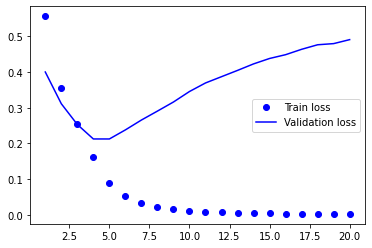

In [126]:
eval_metric(base_history, 'loss')

In [127]:
reduced_model = models.Sequential()
reduced_model.add(layers.Dense(32, activation='relu', input_shape=(NB_WORDS,)))
reduced_model.add(layers.Dense(2, activation='softmax'))
reduced_model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_25 (Dense)             (None, 32)                320032    
_________________________________________________________________
dense_26 (Dense)             (None, 2)                 66        
Total params: 320,098
Trainable params: 320,098
Non-trainable params: 0
_________________________________________________________________


In [128]:
reduced_history = deep_model(reduced_model)

In [129]:
def compare_loss_with_baseline(h, model_name):
    loss_base_model = base_history.history['val_loss']
    loss_model = h.history['val_loss']

    e = range(1, NB_START_EPOCHS + 1)

    plt.plot(e, loss_base_model, 'bo', label='Validation Loss Baseline Model')
    plt.plot(e, loss_model, 'b', label='Validation Loss ' + model_name)
    plt.legend()
    plt.show()

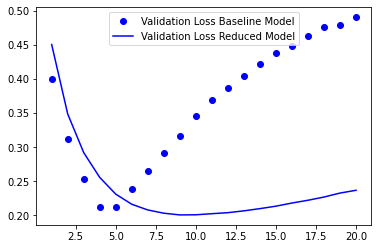

In [130]:
compare_loss_with_baseline(reduced_history, 'Reduced Model')

In [131]:
reg_model = models.Sequential()
reg_model.add(layers.Dense(64, kernel_regularizer=regularizers.l2(0.001), activation='relu', input_shape=(NB_WORDS,)))
reg_model.add(layers.Dense(64, kernel_regularizer=regularizers.l2(0.001), activation='relu'))
reg_model.add(layers.Dense(2, activation='softmax'))
reg_model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_27 (Dense)             (None, 64)                640064    
_________________________________________________________________
dense_28 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_29 (Dense)             (None, 2)                 130       
Total params: 644,354
Trainable params: 644,354
Non-trainable params: 0
_________________________________________________________________


In [132]:
reg_history = deep_model(reg_model)

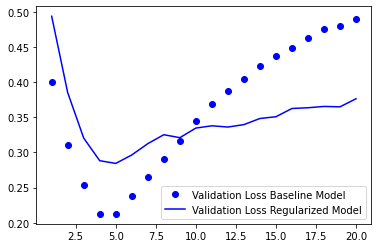

In [133]:
compare_loss_with_baseline(reg_history, 'Regularized Model')

In [134]:
drop_model = models.Sequential()
drop_model.add(layers.Dense(64, activation='relu', input_shape=(NB_WORDS,)))
drop_model.add(layers.Dropout(0.5))
drop_model.add(layers.Dense(64, activation='relu'))
drop_model.add(layers.Dropout(0.5))
drop_model.add(layers.Dense(2, activation='softmax'))
drop_model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_30 (Dense)             (None, 64)                640064    
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_31 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_32 (Dense)             (None, 2)                 130       
Total params: 644,354
Trainable params: 644,354
Non-trainable params: 0
_________________________________________________________________


In [135]:
drop_history = deep_model(drop_model)


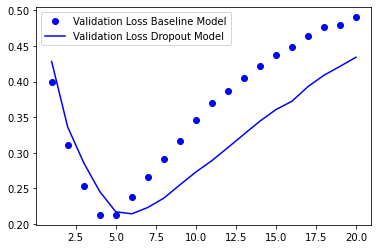

In [136]:
compare_loss_with_baseline(drop_history, 'Dropout Model')

In [137]:
def test_model(model, epoch_stop):
    model.fit(X_train_oh
              , y_train_oh
              , epochs=epoch_stop
              , batch_size=BATCH_SIZE
              , verbose=0)
    results = model.evaluate(X_test_oh, y_test_oh)
    
    return results

In [138]:
X_train_oh.shape

(10386, 10000)

In [139]:
base_results = test_model(base_model, 4)
print('/n')
print('Test accuracy of baseline model: {0:.2f}%'.format(base_results[1]*100))

37/37 [==============================] - 0s 2ms/step - loss: 0.4576 - accuracy: 0.9100
/n
Test accuracy of baseline model: 91.00%


In [140]:
reduced_results = test_model(reduced_model, 10)
print('/n')
print('Test accuracy of reduced model: {0:.2f}%'.format(reduced_results[1]*100))

37/37 [==============================] - 0s 2ms/step - loss: 0.2723 - accuracy: 0.9203
/n
Test accuracy of reduced model: 92.03%


In [141]:
reg_results = test_model(reg_model, 5)
print('/n')
print('Test accuracy of regularized model: {0:.2f}%'.format(reg_results[1]*100))

37/37 [==============================] - 0s 3ms/step - loss: 0.3291 - accuracy: 0.9203
/n
Test accuracy of regularized model: 92.03%


In [142]:
model= drop_model

In [144]:

def predict_class(text, model):
    '''Function to predict sentiment class of the passed text'''
    
    sentiment_classes = ['Negative', 'Positive']
    max_len=50
    
    # Transforms text to a sequence of integers using a tokenizer object
    xt = tk.texts_to_sequences(text)
    print(xt)
    ohs = np.zeros((1,10000))
    print(ohs.shape)
    for i in xt[0] :
        ohs[0][i]= 1
    print(ohs)
    # Do the prediction using the loaded model
    yt = model.predict(ohs).argmax()
    # Print the predicted sentiment
    print('The predicted sentiment is', sentiment_classes[yt])